Make 3d plots of gridded glacier change<br>
Brandon Tober<br>
10JAN2026<br><br>

The objective of this notebook is to demonstrate how to take PyGEM binned model projections and create 2D plots and animations.
Towards the end of the PyGEM-notebooks [advanced_test_spinup_elev_change_calib](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test_spinup_elev_change_calib.ipynb) notebook one will find a brief demonstration of redistributing binned projections to 2D. This notebook builds on this, showing how to get the "median flowline" from an ensemble of GCMs, and then make 3D plots/animations from that. Note, this uses OGGM's glacier3dviz tool to make some nice 3D plots - see https://glacier3dviz.oggm.org/tutorials/welcome.html# for more details and more advanced tutorials. Also note, this notebook serves only as a demonstration, and will not run in place without one first running an ensemble of PyGEM simulations. Similarly, paths and various settings may need to be tweaked for one's own usage.

glacier3dviz install:
Note, one may wish to duplicate their PyGEM conda environment before installing glacier3dviz, in case there are any dependency issues...

Install as follows:<br>
```!pip install --upgrade git+https://github.com/OGGM/glacier3dviz.git```

In [1]:
import os
import glob
import json
import warnings
import pandas as pd
import geopandas as gpd
import cmocean
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()
import pygem.oggm_compat as oggm_compat
from oggm import cfg, workflow, tasks
cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = '../data/PyGEM_data/oggm_gdirs_L4p/'     # one may need to change this working directory depending on where their data is stored

# glacier3dviz imports
from glacier3dviz.tools import Glacier3DViz, get_centered_lon_lat
from glacier3dviz.tools.map_annotations import ArrowAnnotation
from glacier3dviz.tools.map_annotations import MaskAnnotation

# matplotlib defaults
plt.rcParams["font.family"] = "times"
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10

First we need to distribute modeled ice thickness to 2d for glaciers of interest.
We'll do this for each a moderate and a high emission scenario, for each available GCM and then take the multi-GCM median.

In [2]:
datpath = f"../data/PyGEM_data/Output/glacierwide_mb_mwea_elev_change_1d_L4p/simulations/01"   # data directorm
oggm_path = f"../data/PyGEM_data/oggm_gdirs_L4p/per_glacier/RGI60-01/"                          # oggm region root path
outpath = '../pres/figs/gridded_plots/'                                                         # output path for saving figs
rgi_glac_numbers = ['1.15645','1.26722']                                                        # list of glaciers - can be as many as we wish - here just Kennicott and Root, which we'll merge later
scenarios = ['ssp126','ssp245','ssp370','ssp585']                                               # scenarios
gcms = os.listdir(datpath)                                                                      # gcms
# remove ERA5 and potential mac .DS_Store
kstorm = ['ERA5','.DS_Store']
for k in kstorm:
    if k in gcms:
        gcms.remove(k)
print(gcms)

['CESM2', 'INM-CM4-8', 'CESM2-WACCM', 'EC-Earth3-Veg', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'EC-Earth3', 'BCC-CSM2-MR', 'GFDL-ESM4', 'INM-CM5-0', 'FGOALS-f3-L', 'NorESM2-MM']


If we have an ensemble of GCMs that were run, we may wish to compute the "median flowline" - from which we'll then redistribute the mass to 2D.

OGGM has a funciton (flowline.compute_fl_diagnostics_quantiles) that works with their glowline diagnostics data. This does not readily take PyGEM binned data, since PyGEM's binned data is in a slightly different format.  Therefore, the funciton below is a modified version of oggm.flowline.compute_fl_diagnostics_quantiles(), which works with PyGEM binned simulations. As written below, only the median is computed. However, one could modify to take the mean or a different quantile.

In [3]:
# compute 'median' flowline for each glacier from all GCMs
# modified from OGGM's flowline.compute_fl_diagnostics_quantiles to work with PyGEMs binned data
def compute_fl_diagnostics_quantiles(gdir,
                                     basedir,
                                     rgiid,
                                     climate_models,
                                     scenario='',
                                     input_filesuffix='',
                                     quantile=0.5,
                                     output_fileprefix='fl_diagnostics',
                                     output_filesuffix='_median',
                                    ):
    """Compute quantile fl_diagnostics (e.g. median flowline of projections)

    This function takes a number of fl_diagnostic files and compute out of them
    quantiles. This could be useful for example for calculating a median
    flowline for different gcm projections which use the same scenario
    (e.g. ssp126).

    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        the glacier directory to process
    basedir : str
        base data directory
    rgiid : str
        glacier rgi id
    climate_models: str or list
        string of list of climate models
    scenario: str
        climate model scenario
    input_filesuffix : str
        filesuffix to be considered for computing quantiles
    quantile : float
        The quantile to compute.
        Default is 0.5 (the median).
    output_fileprefix : str
        The fileprefix of the resulting flowline diagnostics.
        Default is 'fl_diagnostics'.
    output_filesuffix : str
        The output_filesuffix of the resulting flowline diagnostics.
        Default is '_median'.
    """
    # if needed convert gcms and scenarios to lists
    if not isinstance(climate_models, str):
        climate_models = list(climate_models)

    # if quantiles is a list with one element, only use this
    if not isinstance(quantile, float) or not (0 <= quantile <= 1):
        raise ValueError("quantile must be a float between [0,1]")

    # get filepath of all fl_diagnostic files
    all_fl_diag_paths= []
    for cm in climate_models:
        all_fl_diag_paths.append(os.path.join(
                            os.path.normpath(basedir), 
                            cm, 
                            scenario,
                            'binned',
                            f"{rgiid.replace("RGI60-", "").lstrip("0")}_{cm}_{scenario}{input_filesuffix}".replace("__","_")))
    # assume all have the same number of flowlines, extract the base structure
    with xr.open_dataset(all_fl_diag_paths[0]) as ds:
        ds_base = ds.load()

    # open each file and append to list
    dss = []
    for fp in all_fl_diag_paths:
        ds = xr.open_dataset(fp)  # open each file
        filename = os.path.basename(fp).split("/")[-1]
        ds = ds.expand_dims({"filename": [filename]})  # create 'filename' dimension
        dss.append(ds)
    
    # concatenate all files
    ds_fl = xr.concat(dss, dim="filename")

    # get numeric variables to compute quantiles for
    numeric_vars = [v for v in ds_fl.data_vars if np.issubdtype(ds_fl[v].dtype, np.number)]

    # compute quantiles
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ds_q = ds_fl[numeric_vars].quantile(quantile, dim="filename")

    # for writing into the nice output structure
    output_filepath = os.path.join(os.path.normpath(gdir.dir),f'{output_fileprefix}{output_filesuffix}.nc')
    
    encode = {var: {'zlib': True, 'complevel': 5} for var in numeric_vars}

    ds_base.to_netcdf(output_filepath, 'w')
    ds_q.to_netcdf(output_filepath, 'a',
                    encoding=encode)

Now let's actually run the function for our glaciers of interest, computing the median flowline for each scenario - one may wish to comment this out if already run
Also, this can be slow if running for many glaciers and it could easily be parallelized.

In [4]:
for gnum in rgi_glac_numbers:
    # init gdir
    rgiid = f'RGI60-0{gnum}'
    print(rgiid)
    gdir = workflow.init_glacier_directories([rgiid])[0]

    for scenario in scenarios:
        compute_fl_diagnostics_quantiles(gdir,
                                        basedir=datpath,
                                        rgiid=rgiid,
                                        climate_models=gcms,
                                        scenario=scenario,
                                        quantile=0.5,                                                   # which quantile to compute
                                        input_filesuffix='_MCMC_ba1_50sets_2000_2100_binned.nc',        # input binned data file suffix
                                        output_fileprefix=gnum,
                                        output_filesuffix=f'_pygem_{scenario}_median')                  # output file suffix

RGI60-01.15645
RGI60-01.26722


Redistribute flowline ice thickness to 2d grid - one may wish to comment out if already run<br>
Note, first we need to overwrite 'model_flowlines.pkl' with flowlines from spinup, otherwise when the necessary OGGM tasks are called, they'll redistribute the mass using the `model_flowlines.pkl` by default, which may not correspond to the flowlines we wish to use from dynamical spinup.

In [5]:
# loop through glaciers, gcms, and scenarios of interest for which to redistribute modeled thickness to 2d 
# NOTE - this is pretty slow and should be parallelized if running many glaciers


calib_datpath = '../data/PyGEM_data/Output/glacierwide_mb_mwea_elev_change_1d_L4p/calibration/01/dh/'

for gnum in rgi_glac_numbers:

    ###
    ### BELOW is only necessary if dynamical spinup was performed! ###
    ###
    fp = f'{calib_datpath}/{gnum}-modelprms_dict.json'
    try:
        with open(fp,'r') as fin:
            dat = json.load(fin)
            ref_startyear = int(dat['MCMC']['ref_period'][0])
        rgiid = f'RGI60-0{gnum}'
        print(rgiid, ref_startyear)

        gdir = workflow.init_glacier_directories([rgiid])[0]

        fls = oggm_compat.get_spinup_flowlines(gdir, y0=ref_startyear)

        # store model_flowlines
        gdir.write_pickle(fls, 'model_flowlines')
    except:
        pass
    ###
    ### ABOVE is only necessary if dynamical spinup was performed! ###
    ###

    # distribute thickness for median flowline (calls PyGEM's bin.postproc.postproc_distribute_ice() function)
    for scenario in scenarios:
        binned_fp = os.path.join(os.path.normpath(gdir.dir),f'{gnum}_pygem_{scenario}_median.nc')
        !postproc_distribute_ice -simpath {binned_fp}

RGI60-01.15645 2000
Processing with 1 cores... 
['../data/PyGEM_data/oggm_gdirs_L4p/per_glacier/RGI60-01/RGI60-01.15/RGI60-01.15645/1.15645_pygem_ssp126_median.nc']
1 glaciers in region 1 are included in this model run: ['15645']
This study is focusing on 1 glaciers in region [1]
Total processing time: 6.126289129257202 s
Processing with 1 cores... 
['../data/PyGEM_data/oggm_gdirs_L4p/per_glacier/RGI60-01/RGI60-01.15/RGI60-01.15645/1.15645_pygem_ssp245_median.nc']
1 glaciers in region 1 are included in this model run: ['15645']
This study is focusing on 1 glaciers in region [1]
Total processing time: 6.37781023979187 s
Processing with 1 cores... 
['../data/PyGEM_data/oggm_gdirs_L4p/per_glacier/RGI60-01/RGI60-01.15/RGI60-01.15645/1.15645_pygem_ssp370_median.nc']
1 glaciers in region 1 are included in this model run: ['15645']
This study is focusing on 1 glaciers in region [1]
Total processing time: 6.330965042114258 s
Processing with 1 cores... 
['../data/PyGEM_data/oggm_gdirs_L4p/per_g

For some glaciers, we may want to merge the gridded data - such as for Kennicott and Root glaciers.  This could easily be extended to merge the gridded results for an entire range, etc.<br>
Comment out/delete this cell if not merging any glaciers

In [6]:
rgi_ids_for_merge = ['RGI60-01.15645',  # Kennicott
                     'RGI60-01.26722',  # Root
                    ]
gdirs_for_merge = workflow.init_glacier_directories(rgi_ids_for_merge)
for scenario in scenarios:  # loop over SSP scenarios
    ds_merged = workflow.merge_gridded_data(
        gdirs_for_merge,
        input_file='gridded_simulation',
        input_filesuffix=f'_pygem_{scenario}_median',
        output_folder=gdirs_for_merge[0].dir,  # by default the final file is saved at cfg.PATHS['working_dir']
        output_filename=f'gridded_simulation_merged_pygem_{scenario}_median',  # the default file is saved as gridded_data_merged.nc
        included_variables='all',  # you also can provide a list of variables here
        add_topography='COPDEM30',  # here we can add topography for the new extend
        reset=True,  # set to True if you want to overwrite an already existing file (for playing around)
    )

In [7]:
# now remove root from list of glaciers since Kennicott and Root were merged
rgi_glac_numbers.remove('1.26722')

Almost time to make some nice plots and animations.  First tom setup for glacier3dviz:

In [8]:
# Modified version of glacier3dviz's plot_centered_globe below to hard-code extents (so that they remain consistent in a larger multi-glacier figure)
# if one does not care about having consistent hard-coded extents, just use glacier3dviz.tools.plot_centered_globe() directly. See https://glacier3dviz.oggm.org/tutorials/advanced_visualizations.html#add-images-as-insets
def plot_centered_globe(ds,
                        filename=None,
                        figsize=(1,1),
                        arrow_length=(15, 5),
                        show=True,
                        ):
    # center_lon, center_lat = get_centered_lon_lat(ds)
    center_lon=-142.25
    center_lat = 60.375
    fig = plt.figure(figsize=figsize)

    # Use Orthographic projection centered at location
    # ortho = ccrs.Orthographic(central_longitude=center_lon,
    #                           central_latitude=center_lat)
    ortho = ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=63,
                                    standard_parallels=(55, 65))
    ax = plt.subplot(1, 1, 1, projection=ortho)
    extent = [-154, -130.5, 57, 65]
    ax.set_extent(extent)
    # Add global features
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,
                   edgecolor='black')

    # Add an red arrow for showing the glacier location
    ax.annotate('',
                xy=get_centered_lon_lat(ds),
                xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
                xytext=arrow_length,
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                color='red',
                                lw=1.))

    # Add gridlines for lat and lon
    ax.gridlines(draw_labels=False, lw=0.2, color='black')

    # ax.set_global()
    ax.axis("off")
    fig.tight_layout()
    # Save the plot
    if filename:
        plt.savefig(filename,
                    transparent=True,
                    # bbox_inches='tight',
                    pad_inches=0,
                    dpi=300)
    if show:

        plt.show()
    else:
        plt.close()

Below are some stylistic arguments that can be tweaked to modify font type, size, colors, colormaps, etc.

In [9]:
fontsize=16
# some constants
background_args_new = {
    'color': 'white' ,
}
north_arrow = ArrowAnnotation(
    text='N',
    arrow_kwargs={'color':'black'},
    text_kwargs={'text_color':'black',
                'font_family':'times',
                'font_size':fontsize},
    y_position=0.5,
    x_position=-0.1,
    arrow_magnitude=0.2,
    text_position_offset=[-0.02, 0.02, 0],
    )
outline = MaskAnnotation(
    mask_data='glacier_ext',
    mask_color=[0, 0, 0, 255],  # provided in RGBA with 255 convention
    add_z=0,  # add some height for plotting the MaskAnnotation on top of topography
)
add_mesh_ice_thick_args_new = {
    'scalar_bar_args': {  # some arguments for the colorbar
        'color': 'black',  # set x_position of colorbar
        'font_family':'times',
        'label_font_size': fontsize,
        'title_font_size': fontsize,
        'width':0.05,
        'height':0.25

    }
}
text_time_args_new = {
    'text': '{:.0f}',
    'position': 'upper_right',
    'font':'times',
    'font_size': fontsize,
    'color':'black'}

Now below is the actual fun of plotting the 3D animations. This chunk of code may be pretty custom-tailored for a certain glacier due primarily to the crop arguments and azimuth. There are also much more advanced things that can be done, such as rotating the animation, zooming, etc. See [here](https://glacier3dviz.oggm.org/tutorials/advanced_visualizations.html#) for more.

1.15645 ssp126


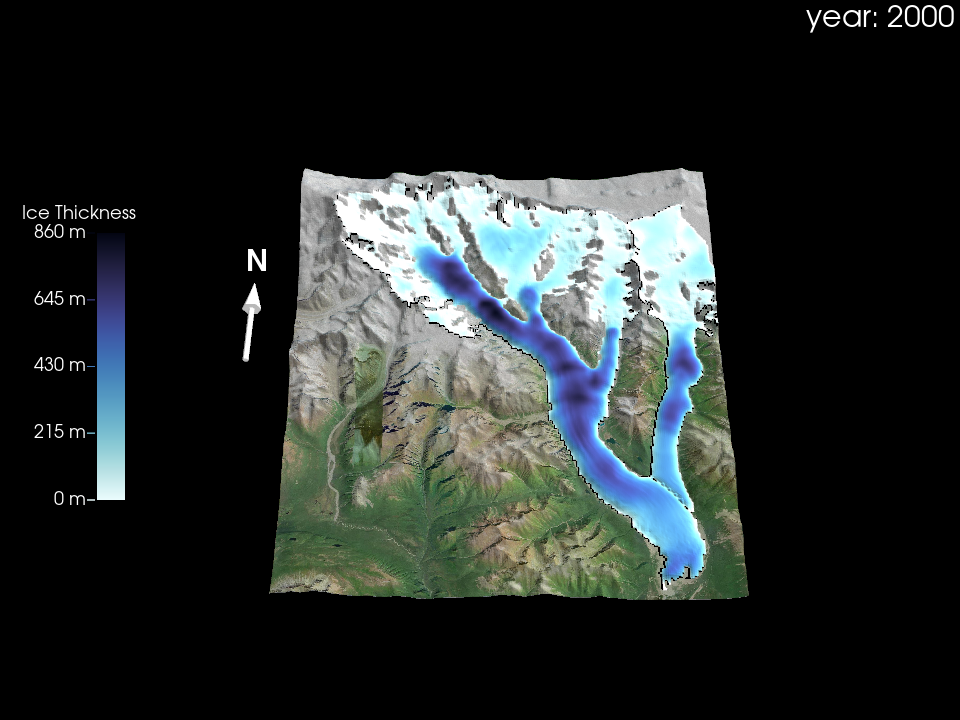

1.15645 ssp245


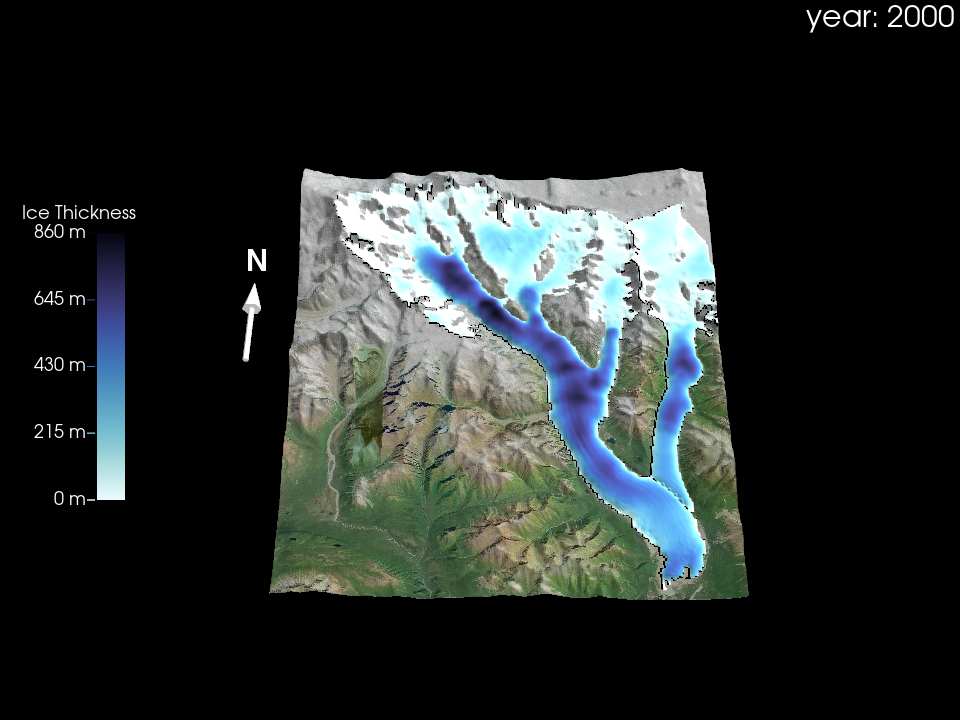

1.15645 ssp370


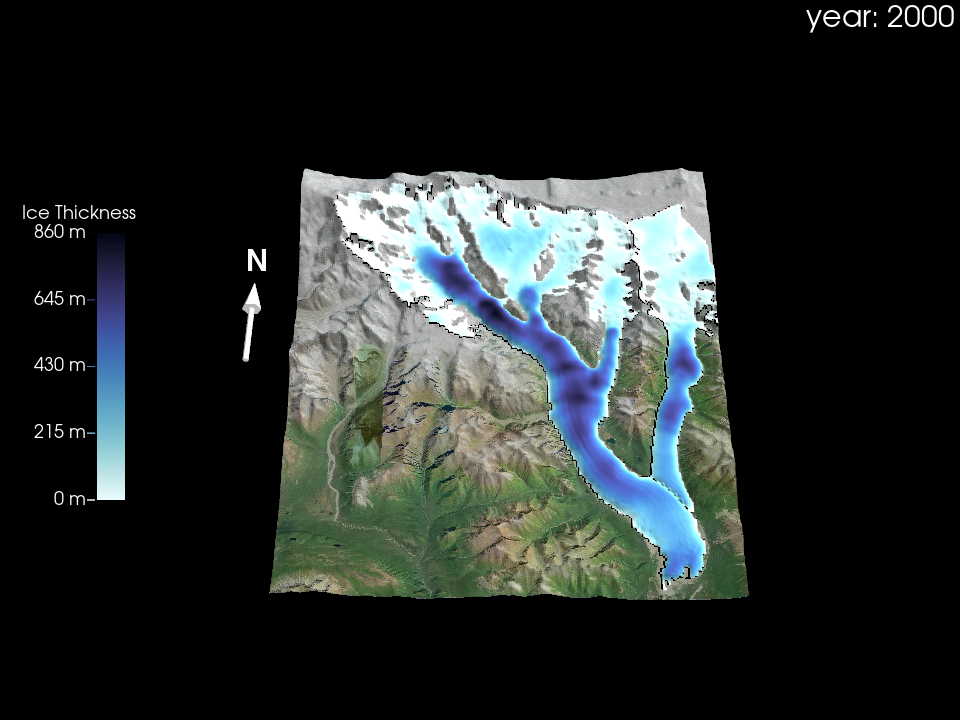

1.15645 ssp585


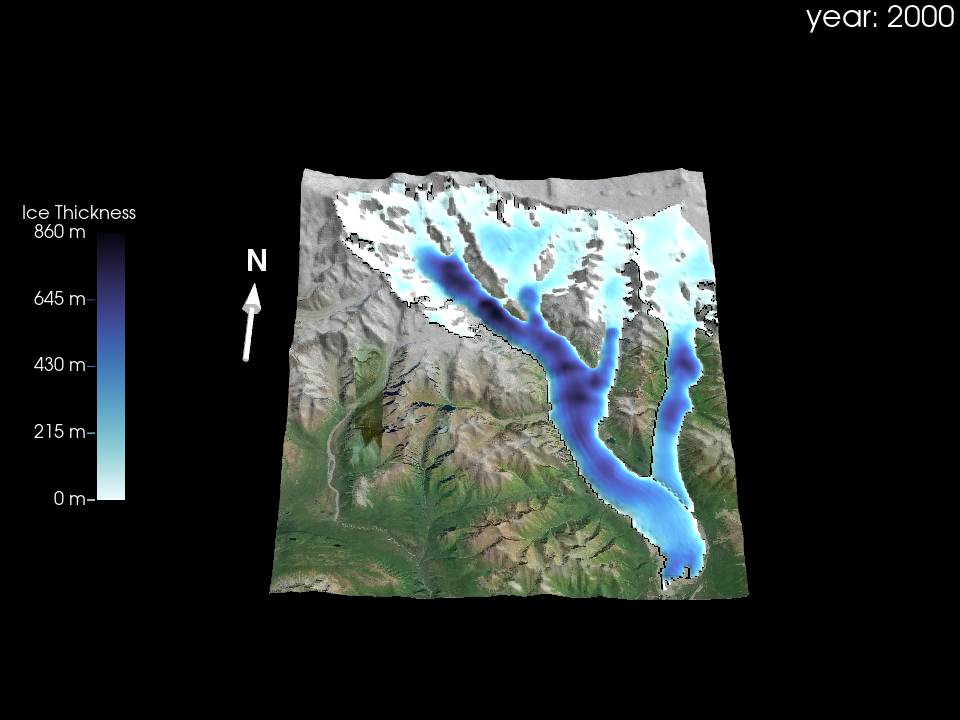

In [10]:
gnum = rgi_glac_numbers[0]      # kennicott in this case

# ensure we have a gnum folder to export to
os.makedirs(f'{outpath}/RGI60-0{gnum}',exist_ok=True)

# for gnum in rgi_glac_numbers:  # loop over glaciers
path = os.path.normpath(
    f"{oggm_path}/RGI60-01.{gnum.split('.')[1][:2]}/"
    f"RGI60-01.{gnum.split('.')[1]}/"
)    
for scenario in scenarios:  # loop over SSP scenarios
    print(gnum, scenario)

    # get gridded simulation ensemble median file path.  for Kennicott/Root, we have a specific path with 'merged' in it.  this may not be the case for other glaciers....
    if gnum=='1.15645':
        fp=os.path.join(path,f'gridded_simulation_merged_pygem_{scenario}_median.nc')
    else:
        fp=os.path.join(path,f'gridded_simulation_pygem_{scenario}_median.nc')

    # Open file
    ds_glac = xr.open_dataset(fp) 

    viz = Glacier3DViz(
        ds_glac,  # dataset for visualization
        x='x',  # x-coordinate name, default is 'x'
        y='y',  # y-coordinate name, default is 'y'
        x_crop=0.55,  # how many grid points should be shown along the x-axis (centered) 
                    # or a crop factor between 0 and 1, which crops in the percentage given by the crop factor.  
        y_crop=0.55,  # how many grid points should be shown along the y-axis (centered)
                    # or a crop factor between 0 and 1, which crops in the percentage given by the crop factor. 
        time='time',  # time coordinate name, default is 'time'
        topo_bedrock='topo',  # bedrock data variable, default is 'bedrock' # IF TOPO DOES NOT WORK TRY BEDROCK
        ice_thickness='simulated_thickness',  # evolving ice thickness variable, default is 'simulated_thickness'
        time_var_display='calendar_year',  # time format displayed, opting for total years here
        camera_args={  # camera view settings, more details later
            'azimuth': -135, # rotate around the z-axis
            'elevation': 20,  # elevation angle above ground
            'zoom': 1,

        },
        use_texture=True,  # decide to use background map (satellite imagery) for texture on the topography
    )

    # slight modification to round the colorbar values to integers
    new_annotations = {
        key: f"{int(round(key))} m"
        for key in viz.var_display_lookuptable_args_default['annotations']
    }

    # colorbar args
    var_display_lookuptable_args_new = {
        'cmap': cmocean.cm.ice_r,  # change the used colormap
        'annotations': new_annotations,  # add our new annotations
    }

    # create animation!
    viz.export_animation(filename=f'{outpath}/RGI60-0{gnum}/RGI60-0{gnum}_{scenario}.mp4',  # filename for the animation, should end with .mp4
                        framerate=20,  # framerate of the animation, affects duration and speed
                        quality=5,  # The range is 0 - 10. Higher quality leads to a larger file.
                        var_display_lookuptable_args=var_display_lookuptable_args_new,
                        additional_annotations=[ArrowAnnotation(
                                                text='N',
                                                y_position=0.5,
                                                x_position=-0.1,
                                                arrow_magnitude=0.2,
                                                text_position_offset=[-0.02, 0.02, 0],
                                                ), 
                                                outline], 
                        );
    
    # create stills at years of interest
    for yr in [2015,2100]:
        viz.plot_year(yr,
                        var_display_lookuptable_args=var_display_lookuptable_args_new,
                        add_mesh_ice_thick_args=add_mesh_ice_thick_args_new,
                        additional_annotations=[north_arrow, outline], 
                        background_args=background_args_new,
                        text_time_args=text_time_args_new,
                        kwargs_screenshot={'transparent_background':True},
                        filepath=f'{outpath}/RGI60-0{gnum}/RGI60-0{gnum}_{scenario}_{yr}.png',
                        show_plot=False)

# plot centered globe - only needs to run once
plot_centered_globe(ds_glac,
                    filename=f'{outpath}/RGI60-0{gnum}/RGI60-0{gnum}_globe.png',
                    show=False)

Load an animation to see how it looks:

In [11]:
viz.show()

For each glacier let's also make glacier-specific plots of the mass timeseries

In [12]:
agg_path = f"../data/PyGEM_data/Output/glacierwide_mb_mwea_elev_change_1d_L4p/simulations/compile/glacier_stats/"

vns = ['mass_annual']

# choose a year to normalize values to
normyear=2015

region = 1

ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_monthly'}

scenario_namedict = {
                    'ssp126':'SSP1-2.6',
                    'ssp245':'SSP2-4.5',
                    'ssp370':'SSP3-7.0',
                    'ssp585':'SSP5-8.5'
                     }

scenarios2plot=['ssp126','ssp245','ssp370','ssp585']
scenario_colordict = {
                    'ssp585':'#a6611a',
                    'ssp370':'#dfc27d',
                    'ssp126':'#80cdc1',
                    'ssp245':'#018571'
                    }

1.15645


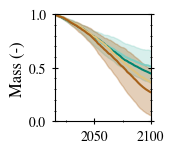

In [13]:
# Filepath
ds_fp = agg_path + '/' + 'glac_mass_annual' + '/' + str(region).zfill(2) + '/'

for gnum in rgi_glac_numbers:
    print(gnum)
    fig,ax=plt.subplots(1,figsize=(1.6  ,1.36))
    
    # loop through scenarios combinations
    # for gcm in gcms:
    for scenario in scenarios:
        # get list of files to open
        ds_fns = glob.glob(f'{ds_fp}/R{str(region).zfill(2)}_glac_mass_annual_{scenario}*.nc')
        if len(ds_fns) == 1:
            ds = xr.open_dataset(ds_fns[0])
        else:
            continue

        # select glacier of interest
        ds_glac = ds.sel(glacier=ds.RGIId == f"RGI60-0{gnum}").squeeze("glacier")

        # merge kennicott and root together root
        if gnum=='1.15645':
            ds_glac = ds.sel(glacier=ds.RGIId.isin(["RGI60-01.15645","RGI60-01.26722"])).sum("glacier")

        time = ds.time.values
        # calculate mass remaining at 2100 relative to 2000 for each glacier and store in larger ds
        ds_glac_median = ds_glac.median(dim='model')
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Degrees of freedom <= 0 for slice",
                category=RuntimeWarning,
            )
            ds_glac_std = ds_glac.std(dim="model")

        ds_glac_median_norm = ds_glac_median / ds_glac_median.sel(time=normyear)
        ds_glac_std_norm = ds_glac_std / ds_glac_median.sel(time=normyear)
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="All-NaN slice encountered",
                category=RuntimeWarning,
            )
            ds_q2p5_norm = ds_glac.quantile(.025,dim='model') / ds_glac_median.sel(time=normyear)
            ds_q97p5_norm = ds_glac.quantile(.975,dim='model') / ds_glac_median.sel(time=normyear)
            # print(ds_q97p5_norm['glac_mass_annual'].values[-1]-ds_q2p5_norm['glac_mass_annual'].values[-1])
            # print(1.96*(ds_glac_std_norm['glac_mass_annual'].values[-1]))
        # ds_iqr = ds_glac.quantile(.75,dim='model') - ds_glac.quantile(.25,dim='model')
        if scenario in scenarios2plot:
            ax.plot(time, ds_glac_median_norm['glac_mass_annual'].values, c=scenario_colordict[scenario], label = scenario_namedict[scenario])
        if scenario in ['ssp126','ssp585']:
            ax.fill_between(time,
                            ds_glac_median_norm['glac_mass_annual'].values - 1.96*(ds_glac_std_norm['glac_mass_annual'].values), 
                            ds_glac_median_norm['glac_mass_annual'].values + 1.96*(ds_glac_std_norm['glac_mass_annual'].values), 
                            color=scenario_colordict[scenario], 
                            alpha=0.3)

    ax.set_xlim([normyear,2100])
    ax.set_ylim([0,1])

    ax.xaxis.set_minor_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.tick_params(which='major', direction='inout', length=5)
    ax.tick_params(which='minor', direction='inout')
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.tick_params(
        axis='y',
        which='both',
        right=True,     # draw ticks on right
        labelright=False  # ticks only, no duplicate labels
    )
    ax.spines['right'].set_visible(True)
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_ylabel('Mass (-)', labelpad=15)
    ax.get_yaxis().set_label_coords(-0.3, 0.5)
    # ax.legend(loc='best',handlelength=1, fontsize=8,borderaxespad=0,labelspacing=.2,borderpad=0.2)
    fig.tight_layout()
    fig.subplots_adjust(
        right=0.9,
        left=0.3,
        top=0.95,
        bottom=0.1625
    )
    fig.savefig(f'{outpath}/RGI60-0{gnum}/RGI60-0{gnum}_norm_annual_mass_all_ssps.png',dpi=400, transparent=False)

1.15645


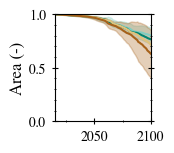

In [14]:
# Filepath
ds_fp = agg_path + '/' + 'glac_area_annual' + '/' + str(region).zfill(2) + '/'

for gnum in rgi_glac_numbers:
    print(gnum)
    fig,ax=plt.subplots(1,figsize=(1.6  ,1.36))
    
    # loop through scenarios combinations
    # for gcm in gcms:
    for scenario in scenarios:
        # get list of files to open
        ds_fns = glob.glob(f'{ds_fp}/R{str(region).zfill(2)}_glac_area_annual_{scenario}*.nc')
        if len(ds_fns) == 1:
            ds = xr.open_dataset(ds_fns[0])
        else:
            continue

        # select glacier of interest
        ds_glac = ds.sel(glacier=ds.RGIId == f"RGI60-0{gnum}").squeeze("glacier")

        # merge kennicott and root together root
        if gnum=='1.15645':
            ds_glac = ds.sel(glacier=ds.RGIId.isin(["RGI60-01.15645","RGI60-01.26722"])).sum("glacier")

        time = ds.time.values
        # calculate mass remaining at 2100 relative to 2000 for each glacier and store in larger ds
        ds_glac_median = ds_glac.median(dim='model')
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Degrees of freedom <= 0 for slice",
                category=RuntimeWarning,
            )
            ds_glac_std = ds_glac.std(dim="model")

        ds_glac_median_norm = ds_glac_median / ds_glac_median.sel(time=normyear)
        ds_glac_std_norm = ds_glac_std / ds_glac_median.sel(time=normyear)
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="All-NaN slice encountered",
                category=RuntimeWarning,
            )
            ds_q2p5_norm = ds_glac.quantile(.025,dim='model') / ds_glac_median.sel(time=normyear)
            ds_q97p5_norm = ds_glac.quantile(.975,dim='model') / ds_glac_median.sel(time=normyear)
            # print(ds_q97p5_norm['glac_area_annual'].values[-1]-ds_q2p5_norm['glac_area_annual'].values[-1])
            # print(1.96*(ds_glac_std_norm['glac_area_annual'].values[-1]))
        # ds_iqr = ds_glac.quantile(.75,dim='model') - ds_glac.quantile(.25,dim='model')
        if scenario in scenarios2plot:
            ax.plot(time, ds_glac_median_norm['glac_area_annual'].values, c=scenario_colordict[scenario], label = scenario_namedict[scenario])
        if scenario in ['ssp126','ssp585']:
            ax.fill_between(time,
                            ds_glac_median_norm['glac_area_annual'].values - 1.96*(ds_glac_std_norm['glac_area_annual'].values), 
                            ds_glac_median_norm['glac_area_annual'].values + 1.96*(ds_glac_std_norm['glac_area_annual'].values), 
                            color=scenario_colordict[scenario], 
                            alpha=0.3)

    ax.set_xlim([normyear,2100])
    ax.set_ylim([0,1])

    ax.xaxis.set_minor_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.tick_params(which='major', direction='inout', length=5)
    ax.tick_params(which='minor', direction='inout')
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.tick_params(
        axis='y',
        which='both',
        right=True,     # draw ticks on right
        labelright=False  # ticks only, no duplicate labels
    )
    ax.spines['right'].set_visible(True)
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_ylabel('Area (-)', labelpad=15)
    ax.get_yaxis().set_label_coords(-0.3, 0.5)
    # ax.legend(loc='best',handlelength=1, fontsize=8,borderaxespad=0,labelspacing=.2,borderpad=0.2)
    fig.tight_layout()
    fig.subplots_adjust(
        right=0.9,
        left=0.3,
        top=0.95,
        bottom=0.1625
    )
    fig.savefig(f'{outpath}/RGI60-0{gnum}/RGI60-0{gnum}_norm_annual_area_all_ssps.png',dpi=400, transparent=False)

Get total Kennicott/Root area

In [15]:
root_kenn_ids = [
                    'RGI60-01.15645',  # Kennicott
                    'RGI60-01.26722',  # Root
                    ]

gdirs = workflow.init_glacier_directories(root_kenn_ids)

print(f'Total Kennicott/Root area: {sum(x.rgi_area_km2 for x in gdirs):,.0f}')

Total Kennicott/Root area: 375
